In [5]:
from dataset.lazy_loader import LazyLoader
from parameters.path import Paths
from matplotlib import pyplot as plt
from modules.hg import HG_softmax2020
import torch


encoder_HG_supervised = HG_softmax2020(num_classes=68, heatmap_size=64)

encoder_HG_supervised.load_state_dict(torch.load(f'{Paths.default.models()}/hg2_e29.pt', map_location="cpu"))
test_img = next(LazyLoader.celeba().loader)[:8]

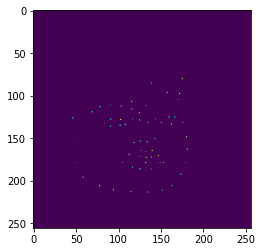

In [6]:
from dataset.probmeasure import ProbabilityMeasure, ProbabilityMeasureFabric, UniformMeasure2DFactory, \
UniformMeasure2D01

hm = encoder_HG_supervised(test_img)

mes = UniformMeasure2DFactory.from_heatmap(hm)

plt.imshow(mes.detach().toImage(256)[0][0])